In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import json

In [3]:
cd ../data/

/srv/home/christinedk/wp_internship/data


In [4]:
ls -lh revision_history/ 

total 3.4G
-rw-r--r-- 1 christinedk wikidev  960M Mar  1 13:21 page_history-advert-meta-info.json
-rw-r--r-- 1 christinedk wikidev  307M Mar  1 13:20 page_history-autobiography-meta-info.json
-rw-r--r-- 1 christinedk wikidev  233M Mar  1 13:21 page_history-fanpov-meta-info.json
-rw-r--r-- 1 christinedk wikidev 1006M Mar  1 13:19 page_history-peacock-meta-info.json
-rw-r--r-- 1 christinedk wikidev  894M Mar  1 13:19 page_history-weasel-meta-info.json


In [5]:
for template in ['autobiography','weasel','advert','fanpov','peacock']:
    print(template)
    df = pd.read_json('/srv/home/christinedk/wp_internship/data/revision_history/page_history-{}-meta-info.json'.format(template),
                 lines=True)
    df = df[df.page_namespace==0]
    print(df.page_id.nunique())
    df = df.sort_values(by=['page_id','revision_id'], ascending=True)
    df['has_template'] = df['has_template'].fillna(0).astype(int)
    
    tag_added = df[(df.has_template.diff()==1)&(~df.revision_is_identity_reverted)][['event_timestamp','event_user_id','page_id','page_title']]
    tag_removed = df[(df.has_template.diff()==-1)&(~df.revision_is_identity_reverted)][['event_timestamp','event_user_id','page_id','page_title']]

    tag_added.to_csv('/srv/home/christinedk/wp_internship/data/tag_events/{}_tag_added.csv'.format(template),
                     index=False)
    tag_removed.to_csv('/srv/home/christinedk/wp_internship/data/tag_events/{}_tag_removed.csv'.format(template),
                     index=False)

autobiography
3823
weasel
1385
advert
7193
fanpov
809
peacock
5085


In [6]:
for template in ['autobiography','weasel','advert','fanpov','peacock']:
    template='autobiography'
    print(template)
    article = pd.read_json('/srv/home/christinedk/wp_internship/data/revision_history/page_history-{}-meta-info.json'.format(template),
                 lines=True)
    article = article[article.page_namespace==0]
    print(article.page_id.nunique())

    talk = pd.read_json('/srv/home/christinedk/wp_internship/data/talk_history/tmp_talk-{}-meta-info.json'.format(template),
                     lines=True)
    print(talk.page_id.nunique())

    article['page_title'] = article.page_title.str.replace('_',' ').astype(str)
    talk['page_title'] = talk.page_title.str[5:]

    talk = talk[['page_id','page_title']].drop_duplicates()
    article = article[['page_id','page_title']].drop_duplicates()

    merged = talk.merge(article,on='page_title')
    merged.columns = ['talk_page_id','page_title','article_page_id']
    print('number of merged pages: {}'.format(len(merged)))

    merged.to_csv('article_talk_mappings/{}.csv'.format(template),index=False)

autobiography
3823
4198
number of merged pages: 3822


In [7]:
# tag usage over time

In [9]:
import matplotlib.pylab as plt

In [10]:
ls /srv/home/christinedk/wp_internship/data/tag_events/

advert_tag_added.csv           fanpov_tag_added.csv     weasel_tag_added.csv
advert_tag_removed.csv         fanpov_tag_removed.csv   weasel_tag_removed.csv
autobiography_tag_added.csv    peacock_tag_added.csv
autobiography_tag_removed.csv  peacock_tag_removed.csv


In [107]:
usage_over_time = {}
tags_added = {}

for tag in ['autobiography','weasel','advert','fanpov','peacock']:
    tag_added = pd.read_csv('/srv/home/christinedk/wp_internship/data/tag_events/{}_tag_added.csv'.format(tag))
    tag_added['event_timestamp']= pd.to_datetime(tag_added['event_timestamp'])

    tag_removed = pd.read_csv('/srv/home/christinedk/wp_internship/data/tag_events/{}_tag_removed.csv'.format(tag))
    tag_removed['event_timestamp']= pd.to_datetime(tag_removed['event_timestamp'])

    date_added = tag_added.event_timestamp.dt.date
    date_added = date_added.value_counts()\
                            .reset_index()\
                            .rename(columns={'index':'date','event_timestamp':'count'})\
                            .sort_values(by='date',ascending=True)

    usage_over_time[tag] = date_added
    print('Tag {}: used on {} days'.format(tag,date_added.date.nunique()))
    
    tags_added[tag] = tag_added

Tag autobiography: used on 2626 days
Tag weasel: used on 1033 days
Tag advert: used on 3783 days
Tag fanpov: used on 643 days
Tag peacock: used on 2965 days


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


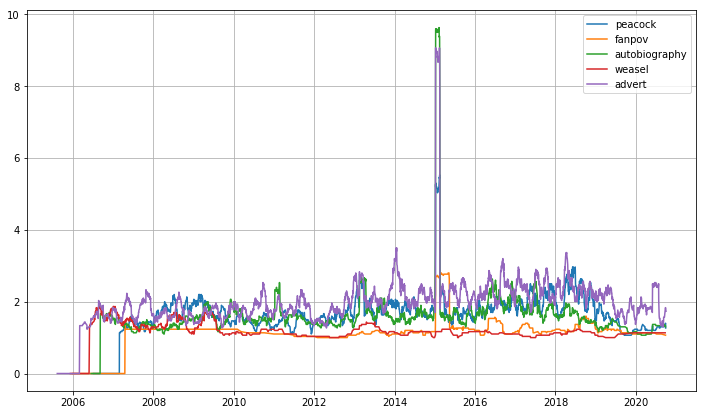

In [108]:
plt.figure(figsize=[12,7])

for t in ['peacock','fanpov','autobiography','weasel','advert']:
    plt.plot(usage_over_time[t]['date'],usage_over_time[t]['count'].rolling(30).mean().fillna(0),label=t)
plt.grid()
plt.legend()
plt.show()

In [109]:
# What happened in 2015?

tag_added = tags_added['advert']

tag_added['event_timestamp'] = pd.to_datetime(tag_added['event_timestamp'])

tag_added['year'] = tag_added.event_timestamp.dt.year
tag_added['month'] = tag_added.event_timestamp.dt.month_name()

tags_per_month = tag_added.groupby(['year','month']).size().reset_index(name='count')
tags_per_month.sort_values(by='count',ascending=False).iloc[:5]

,year,month,count
115,2015,January,253
124,2016,August,89
154,2018,March,85
89,2013,December,84
139,2017,January,83


In [100]:
jan2015 = tag_added[(tag_added.event_timestamp.dt.year==2015) & (tag_added.event_timestamp.dt.month==1)]

jan2015.groupby('page_title').size().sort_values(ascending=False).iloc[:5]

page_title
Richard_Pestell    2
Pavan_Sukhdev      2
AMFJ               1
Nova_Spivack       1
Molly_Melching     1
dtype: int64

In [99]:
jan2015.groupby('event_user_id').size().sort_values(ascending=False).iloc[:5]

event_user_id
7328338.0     203
1862829.0      19
1219.0          2
22359416.0      2
55327.0         2
dtype: int64

In [ ]:
# What about the other tags?

In [124]:
from IPython.display import display, HTML

tags_by_bad_user = pd.DataFrame()

for tag in ['peacock','fanpov','autobiography','weasel','advert']:
    tag_added = tags_added[tag]
    tag_added['event_timestamp'] = pd.to_datetime(tag_added['event_timestamp'])
    tag_added['tag'] = tag
    tag_added['year'] = tag_added.event_timestamp.dt.year
    tag_added['month'] = tag_added.event_timestamp.dt.month
    tags_by_bad_user = pd.concat([tags_by_bad_user,tag_added[tag_added.event_user_id==7328338.0]])
    
    jan2015 = tag_added[(tag_added.year==2015) & (tag_added.month==1)]
    print(tag)
    display(jan2015.groupby('event_user_id').size().sort_values(ascending=False).reset_index().iloc[:3])
    
    

peacock


,event_user_id,0
0,7328338.0,98
1,1862829.0,12
2,21757787.0,3


fanpov


,event_user_id,0
0,7328338.0,49
1,1862829.0,2
2,11308236.0,1


autobiography


,event_user_id,0
0,7328338.0,202
1,1862829.0,29
2,1646408.0,3


weasel


,event_user_id,0
0,7328338.0,5
1,1862829.0,2
2,2298426.0,1


advert


,event_user_id,0
0,7328338.0,203
1,1862829.0,19
2,1219.0,2


In [133]:
tags_by_bad_user.groupby(['tag','year','month']).size().sort_values(ascending=False)[:10]

tag            year  month
advert         2015  1        203
autobiography  2015  1        202
peacock        2015  1         98
fanpov         2015  1         49
autobiography  2011  1         20
fanpov         2016  4          6
advert         2011  1          6
weasel         2015  1          5
advert         2012  12         4
               2016  4          4
dtype: int64

In [ ]:
# re-plot usage without rogue user

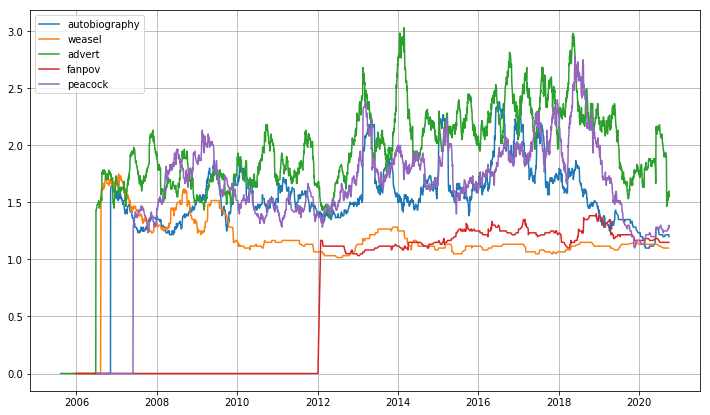

In [153]:
plt.figure(figsize=[12,7])

for tag in ['autobiography','weasel','advert','fanpov','peacock']:
    tag_added = tags_added[tag]
    tag_added = tag_added[tag_added.event_user_id!=7328338.0]
    
    date_added = tag_added.event_timestamp.dt.date
    date_added = date_added.value_counts()\
                            .reset_index()\
                            .rename(columns={'index':'date','event_timestamp':'counts'})\
                            .sort_values(by='date',ascending=True)

    #plt.plot(date_added.date.values.tolist(),date_added.counts.tolist(),label=tag)
    plt.plot(date_added.date.values.tolist(),date_added.counts.rolling(60).mean().fillna(0).tolist(),label=tag)
plt.grid()
plt.legend()
plt.show()